Trying to model my data based on the notebooks to core features on the pymc.io site.
Found here: https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html#id1

In [9]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import xarray as xr
import pytensor.tensor as at
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


sys.path.append('../')
from util.preprocessing_utils import standardize_column
from util.dataframe_utils import analyse_columns

In [10]:
df = pd.read_csv('../data/processed/ProcessedTweets.csv')

In [11]:
# to keep things clean, let's first drop all the columns that we won't be using

df = df.drop(['tweet_id', 'negative_reason', 'negative_reason_confidence', 
              'name', 'retweet_count', 'text', 'tweet_created', 'tweet_location',
              'user_timezone',], axis=1)
df.head()

,airline_sentiment,airline_sentiment_confidence,airline,fractional_hour,hour_sin,hour_cos
0,0,1.0000,0,11.597778,0.105107,-0.994461
1,1,0.3486,0,11.266389,0.190880,-0.981613
2,0,0.6837,0,11.263333,0.191666,-0.981460
3,2,1.0000,0,11.260000,0.192522,-0.981293
4,2,1.0000,0,11.245833,0.196160,-0.980572


In [12]:
airline_mapping = {
    0: 'virgin_america',
    1: 'united',
    2: 'southwest',
    3: 'delta',
    4: 'us_airways',
    5: 'american'
}

df['airline'] = df['airline'].map(airline_mapping)
df  = pd.get_dummies(df, columns=['airline'])

df.head()

,airline_sentiment,airline_sentiment_confidence,fractional_hour,hour_sin,hour_cos,airline_american,airline_delta,airline_southwest,airline_united,airline_us_airways,airline_virgin_america
0,0,1.0000,11.597778,0.105107,-0.994461,False,False,False,False,False,True
1,1,0.3486,11.266389,0.190880,-0.981613,False,False,False,False,False,True
2,0,0.6837,11.263333,0.191666,-0.981460,False,False,False,False,False,True
3,2,1.0000,11.260000,0.192522,-0.981293,False,False,False,False,False,True
4,2,1.0000,11.245833,0.196160,-0.980572,False,False,False,False,False,True


In [13]:
X = df.drop('airline_sentiment', axis=1)
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [14]:
X_train -= X_train.mean()
X_train /= X_train.std()

N, D = X.shape
D0 = int(D / 2)

X_train.head()

,airline_sentiment_confidence,fractional_hour,hour_sin,hour_cos,airline_american,airline_delta,airline_southwest,airline_united,airline_us_airways,airline_virgin_america
10742,-1.655688,0.496282,-0.993894,-0.505584,-0.481037,-0.424866,-0.447744,-0.593102,2.011406,-0.186816
2121,0.612934,1.512395,-0.946956,1.609548,-0.481037,-0.424866,-0.447744,1.685905,-0.497122,-0.186816
11031,0.612934,1.126718,-1.274298,0.837309,-0.481037,-0.424866,-0.447744,-0.593102,2.011406,-0.186816
13113,0.612934,-0.297571,0.372182,-1.078716,2.078665,-0.424866,-0.447744,-0.593102,-0.497122,-0.186816
7184,-1.523541,-0.669193,1.003317,-0.704672,-0.481037,2.353485,-0.447744,-0.593102,-0.497122,-0.186816


In [15]:
analyse_columns(X_train)

,Column,Data Type,Missing Values,Missing Ratio (%),Unique Values
0,airline_sentiment_confidence,float64,0,0.00%,936
1,fractional_hour,float64,0,0.00%,10736
2,hour_sin,float64,0,0.00%,10527
3,hour_cos,float64,0,0.00%,10519
4,airline_american,float64,0,0.00%,2
5,airline_delta,float64,0,0.00%,2
6,airline_southwest,float64,0,0.00%,2
7,airline_united,float64,0,0.00%,2
8,airline_us_airways,float64,0,0.00%,2
9,airline_virgin_america,float64,0,0.00%,2


In [26]:

with pm.Model(coords={"predictors": X_train.columns.values}) as test_score_model:
    sigma = pm.HalfNormal("sigma", 25)
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")

    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )

    beta0 = pm.Normal("beta0", 100, 25.0)

    sentiment = pm.Normal("sentiment", beta0 + at.dot(X_train.values, beta), sigma, observed=y_train.values)
    nuts_sampler_kwargs = {'target_accept': 0.98, 'max_treedepth': 12}
    trace = pm.sample(1000, tune=1000, nuts_sampler_kwargs=nuts_sampler_kwargs, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 434 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 208 divergences after tuning. Increase `target_accept` or reparameterize.


In [27]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z[airline_sentiment_confidence],1.528,0.593,0.391,2.568,0.027,0.019,365.0,164.0,1.01
z[fractional_hour],0.205,0.580,-0.964,1.414,0.016,0.013,1285.0,1290.0,1.01
z[hour_sin],-0.270,0.577,-1.489,0.883,0.023,0.016,605.0,524.0,1.01
z[hour_cos],0.632,0.507,0.026,1.547,0.025,0.017,279.0,439.0,1.02
z[airline_american],0.515,0.789,-0.978,2.070,0.082,0.058,88.0,346.0,1.04
z[airline_delta],-1.080,0.675,-2.318,0.173,0.066,0.047,97.0,94.0,1.04
z[airline_southwest],-0.780,0.882,-2.550,0.925,0.171,0.122,36.0,33.0,1.09
z[airline_united],0.396,0.883,-1.150,2.067,0.074,0.053,154.0,945.0,1.03
z[airline_us_airways],1.044,0.553,0.178,2.175,0.022,0.016,643.0,1315.0,1.00
z[airline_virgin_america],-0.833,0.626,-2.164,0.250,0.094,0.067,44.0,36.0,1.08


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'c2'}>, <Axes: title={'center': 'c2'}>]],
      dtype=object)

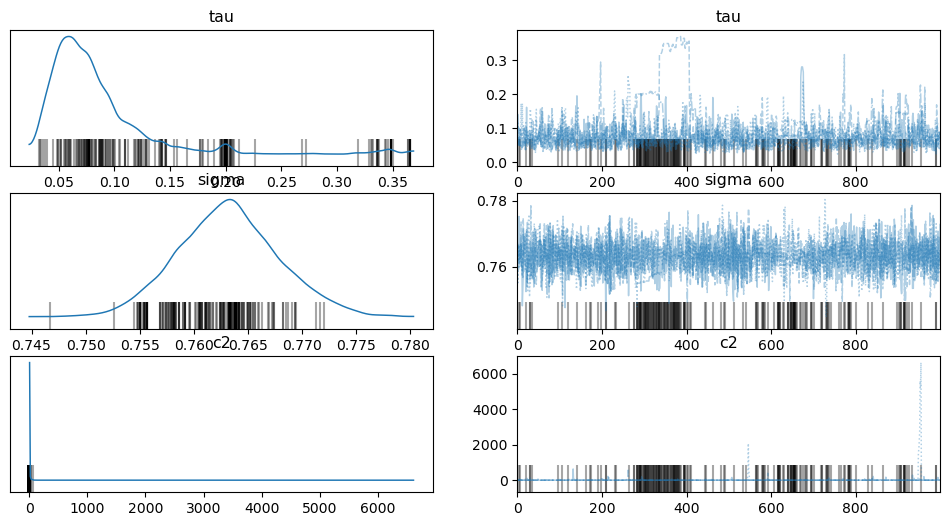

In [31]:
az.plot_trace(trace, var_names=["tau", "sigma", "c2"], combined=True)

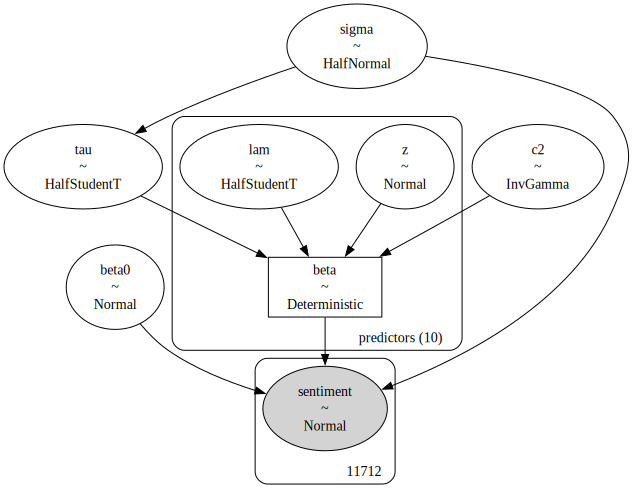

In [23]:
pm.model_to_graphviz(test_score_model)